In [25]:
# Setup: Install POT and import libraries
# !pip install POT  # Uncomment this line if running in Google Colab

import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
from torchvision import datasets

print("Libraries imported successfully.")

Libraries imported successfully.


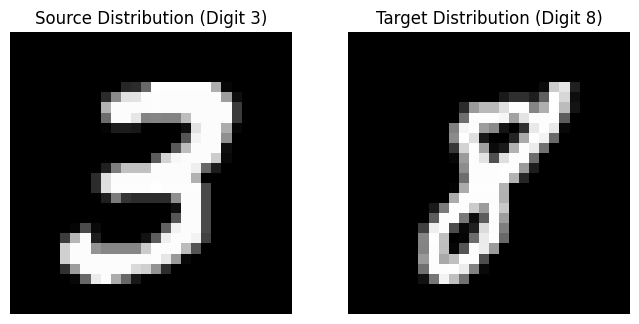

In [26]:
# Data Prep: Load MNIST via torchvision and select two digits
# Download MNIST (PIL images) and convert to numpy arrays
mnist_train = datasets.MNIST(root='.', train=True, download=True)
x_train = np.array([np.array(img, dtype=np.float64) for img, _ in mnist_train])
y_train = np.array([label for _, label in mnist_train])

# Select a '3' and an '8'
idx3 = np.where(y_train == 3)[0][0]
idx8 = np.where(y_train == 8)[0][0]

img1 = x_train[idx3].astype(np.float64)
img2 = x_train[idx8].astype(np.float64)

# Normalize so pixel intensities sum to 1 (probability distributions)
img1 /= img1.sum()
img2 /= img2.sum()

# Flatten for processing
n_pixels = 28 * 28
a = img1.flatten()
b = img2.flatten()

# Visualize the chosen images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title("Source Distribution (Digit 3)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title("Target Distribution (Digit 8)")
plt.axis('off')
plt.show()

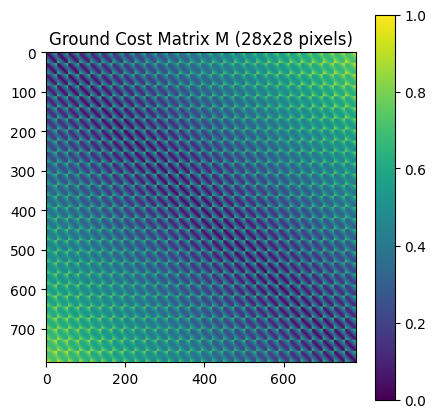

In [27]:
# Geometry: Create Ground Cost Matrix based on pixel coordinates

# Create a grid of coordinates (x, y)
x, y = np.mgrid[0:28, 0:28]
coords = np.vstack((x.flatten(), y.flatten())).T

# Compute Euclidean distance matrix between all pairs of pixels
# M[i, j] is the distance between pixel i and pixel j
M = ot.dist(coords, coords, metric='euclidean')

# Normalize M for numerical stability (optional but recommended)
M /= M.max()

plt.figure(figsize=(5, 5))
plt.imshow(M, cmap='viridis')
plt.title("Ground Cost Matrix M (28x28 pixels)")
plt.colorbar()
plt.show()

In [28]:
# Metric Comparison: Euclidean vs. Earth Mover's Distance

# 1. Euclidean Distance (L2 Norm)
# Does not consider geometry; treats pixels as independent features.
euclidean_dist = np.linalg.norm(a - b)

# 2. Earth Mover's Distance (Wasserstein-1)
# Computes the minimum cost to transport mass from 'a' to 'b' given cost matrix M.
# ot.emd2 returns the cost value.
emd_dist = ot.emd2(a, b, M)

print(f"Euclidean Distance: {euclidean_dist:.4f}")
print(f"Earth Mover's Distance: {emd_dist:.4f}")

# Comment:
# Notice that EMD gives a meaningful distance based on the geometry of the image.
# Even if two digits are non-overlapping, EMD will be proportional to how far the pixels need to move.
# Euclidean distance would just be constant for non-overlapping shapes (sqrt(sum(a^2) + sum(b^2))).

Euclidean Distance: 0.0752
Earth Mover's Distance: 0.0436


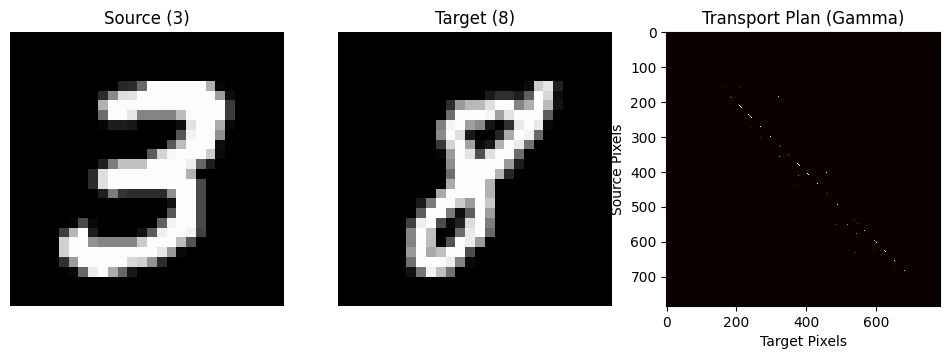

The Transport Plan shows which source pixels map to which target pixels.


In [29]:
# Visualization: Transport Plan

# Compute the optimal transport plan (matrix gamma)
# gamma[i, j] is the amount of mass moved from pixel i in source to pixel j in target.
gamma = ot.emd(a, b, M)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Source (3)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Target (8)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gamma, cmap='hot', interpolation='nearest')
plt.title("Transport Plan (Gamma)")
plt.xlabel("Target Pixels")
plt.ylabel("Source Pixels")
plt.show()

print("The Transport Plan shows which source pixels map to which target pixels.")

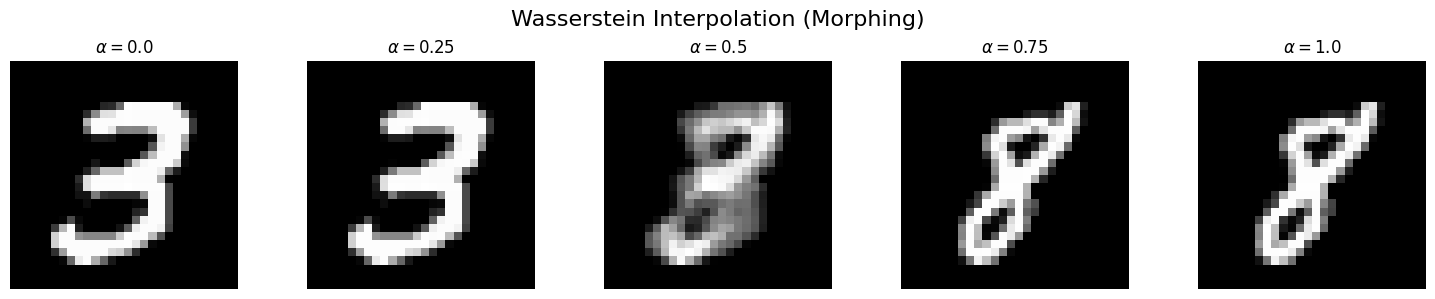

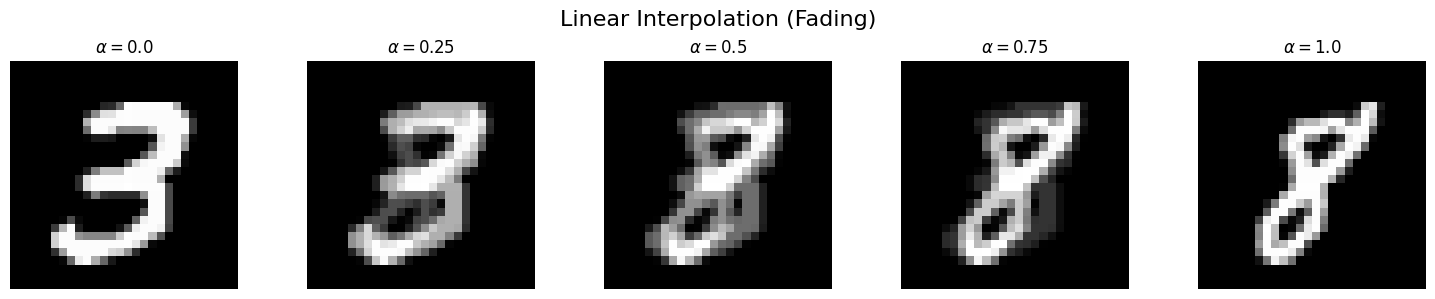

In [30]:
# Interpolation: Wasserstein Barycenters
# We will compute the interpolation between the two images for different weights alpha.

# Stack the two flattened images into a matrix A (d x 2)
A = np.vstack((a, b)).T

# Regularization parameter for Sinkhorn (entropic regularization)
# A small value makes it closer to exact OT but slower/less stable.
reg = 1e-3 

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

plt.figure(figsize=(15, 3))

for i, alpha in enumerate(alphas):
    # Weights for the barycenter [1-alpha, alpha]
    weights = np.array([1 - alpha, alpha])
    
    # Compute Wasserstein barycenter
    # This finds the distribution that minimizes the weighted sum of Wasserstein distances to the inputs.
    barycenter = ot.bregman.barycenter(A, M, reg, weights)
    
    # Reshape back to 28x28 image
    img_interp = barycenter.reshape(28, 28)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_interp, cmap='gray')
    plt.title(f"$\\alpha={alpha}$")
    plt.axis('off')

plt.suptitle("Wasserstein Interpolation (Morphing)", fontsize=16)
plt.tight_layout()
plt.show()

# Comparison with Linear Interpolation
plt.figure(figsize=(15, 3))
for i, alpha in enumerate(alphas):
    # Linear interpolation
    img_linear = (1 - alpha) * img1 + alpha * img2
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_linear, cmap='gray')
    plt.title(f"$\\alpha={alpha}$")
    plt.axis('off')

plt.suptitle("Linear Interpolation (Fading)", fontsize=16)
plt.tight_layout()
plt.show()

# Comment:
# Wasserstein interpolation moves the mass physically (morphing),
# while linear interpolation just fades one image out and the other in.

## Animation: Morphing vs Fading

The static plots above show the interpolation at fixed steps. Below, we generate an animation to visualize the smooth transition.

In [31]:
from matplotlib import animation
from IPython.display import HTML

# Setup figure for animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

def update(frame):
    alpha = frame / 20.0  # 20 frames from 0 to 1
    weights = np.array([1 - alpha, alpha])
    
    # Wasserstein
    barycenter = ot.bregman.barycenter(A, M, reg, weights)
    img_interp = barycenter.reshape(28, 28)
    
    # Linear
    img_linear = (1 - alpha) * img1 + alpha * img2
    
    ax1.clear()
    ax1.imshow(img_interp, cmap='gray')
    ax1.set_title(f"Wasserstein (alpha={alpha:.2f})")
    ax1.axis('off')
    
    ax2.clear()
    ax2.imshow(img_linear, cmap='gray')
    ax2.set_title(f"Linear (alpha={alpha:.2f})")
    ax2.axis('off')

anim = animation.FuncAnimation(fig, update, frames=21, interval=200)
plt.close() # Prevent static display
HTML(anim.to_jshtml())

## Embedding with Optimal Transport Distances

We can use the Earth Mover's Distance as a metric to embed the digits into a 2D space. This allows us to visualize how "close" different digits are in terms of their geometry.

Since computing OT distances is expensive, we will select a small subset of the dataset (e.g., 10 images per digit).

In [37]:
# Data Selection for t-SNE
# We'll select a subset of images to compute the pairwise OT distance matrix.

n_per_digit = 30
subset_indices = []
subset_labels = []

for digit in range(10):
    indices = np.where(y_train == digit)[0][:n_per_digit]
    subset_indices.extend(indices)
    subset_labels.extend([digit] * n_per_digit)

subset_images = x_train[subset_indices].astype(np.float64)
subset_labels = np.array(subset_labels)

# Normalize
subset_images = subset_images.reshape(len(subset_images), -1) # Flatten
subset_images /= subset_images.sum(axis=1, keepdims=True)

print(f"Selected {len(subset_images)} images ({n_per_digit} per digit).")

Selected 300 images (30 per digit).


Using 8 cores for computation.
Computing pairwise Wasserstein distances...
Total pairs to compute: 44850


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 1616 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 5648 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 10832 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done 17168 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done 24656 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done 33296 tasks      | elapsed:   30.7s
[Parallel(n_jobs=8)]: Done 43088 tasks      | elapsed:   37.6s
[Parallel(n_jobs=8)]: Done 44850 out of 44850 | elapsed:   38.9s finished


Distance matrix computed.


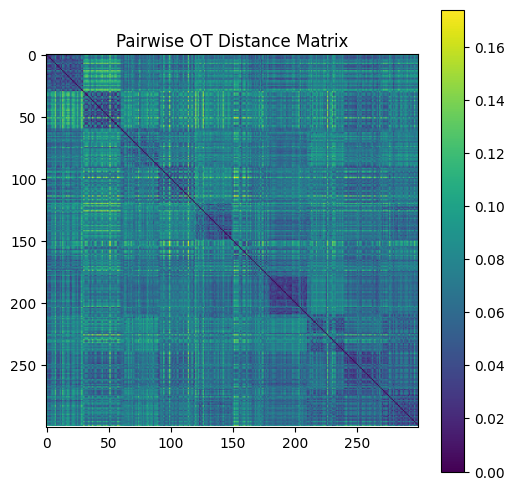

In [38]:
# Compute Pairwise OT Distance Matrix (Parallelized)
import multiprocessing
from joblib import Parallel, delayed

n_cores = multiprocessing.cpu_count()
print(f"Using {n_cores} cores for computation.")

n_samples = len(subset_images)
D_ot = np.zeros((n_samples, n_samples))

# Define helper function for parallel execution
def compute_ot_pair(i, j, img_i, img_j, M):
    # ot.emd2 returns the transport cost
    val = ot.emd2(img_i, img_j, M)
    return i, j, val

print("Computing pairwise Wasserstein distances...")

# Create list of pairs (upper triangle)
pairs = [(i, j) for i in range(n_samples) for j in range(i + 1, n_samples)]
print(f"Total pairs to compute: {len(pairs)}")

# Run in parallel with joblib verbose output
results = Parallel(n_jobs=n_cores, verbose=5)(
    delayed(compute_ot_pair)(i, j, subset_images[i], subset_images[j], M) 
    for i, j in pairs
)

# Fill the matrix
for i, j, val in results:
    D_ot[i, j] = val
    D_ot[j, i] = val

print("Distance matrix computed.")

plt.figure(figsize=(6, 6))
plt.imshow(D_ot, cmap='viridis')
plt.title("Pairwise OT Distance Matrix")
plt.colorbar()
plt.show()

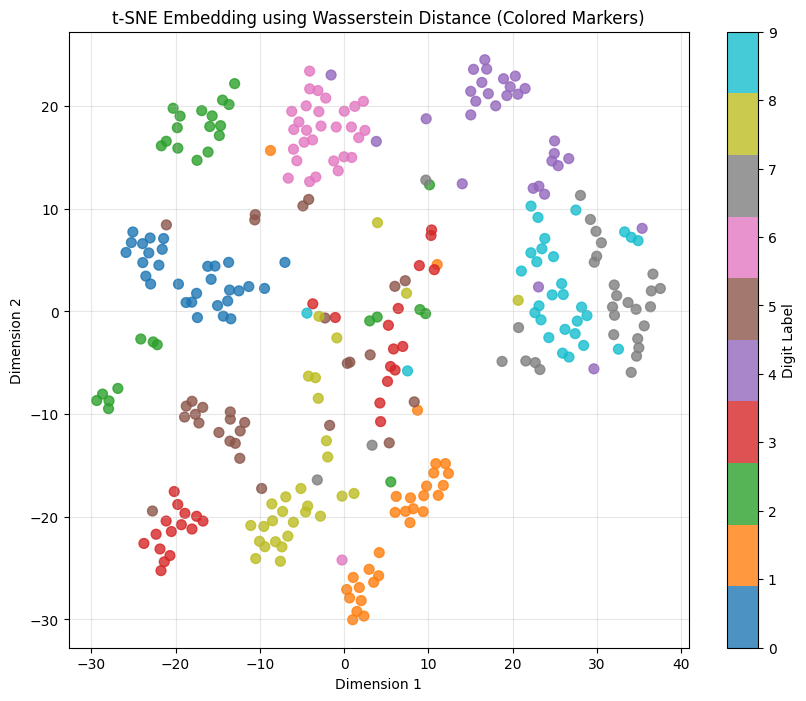

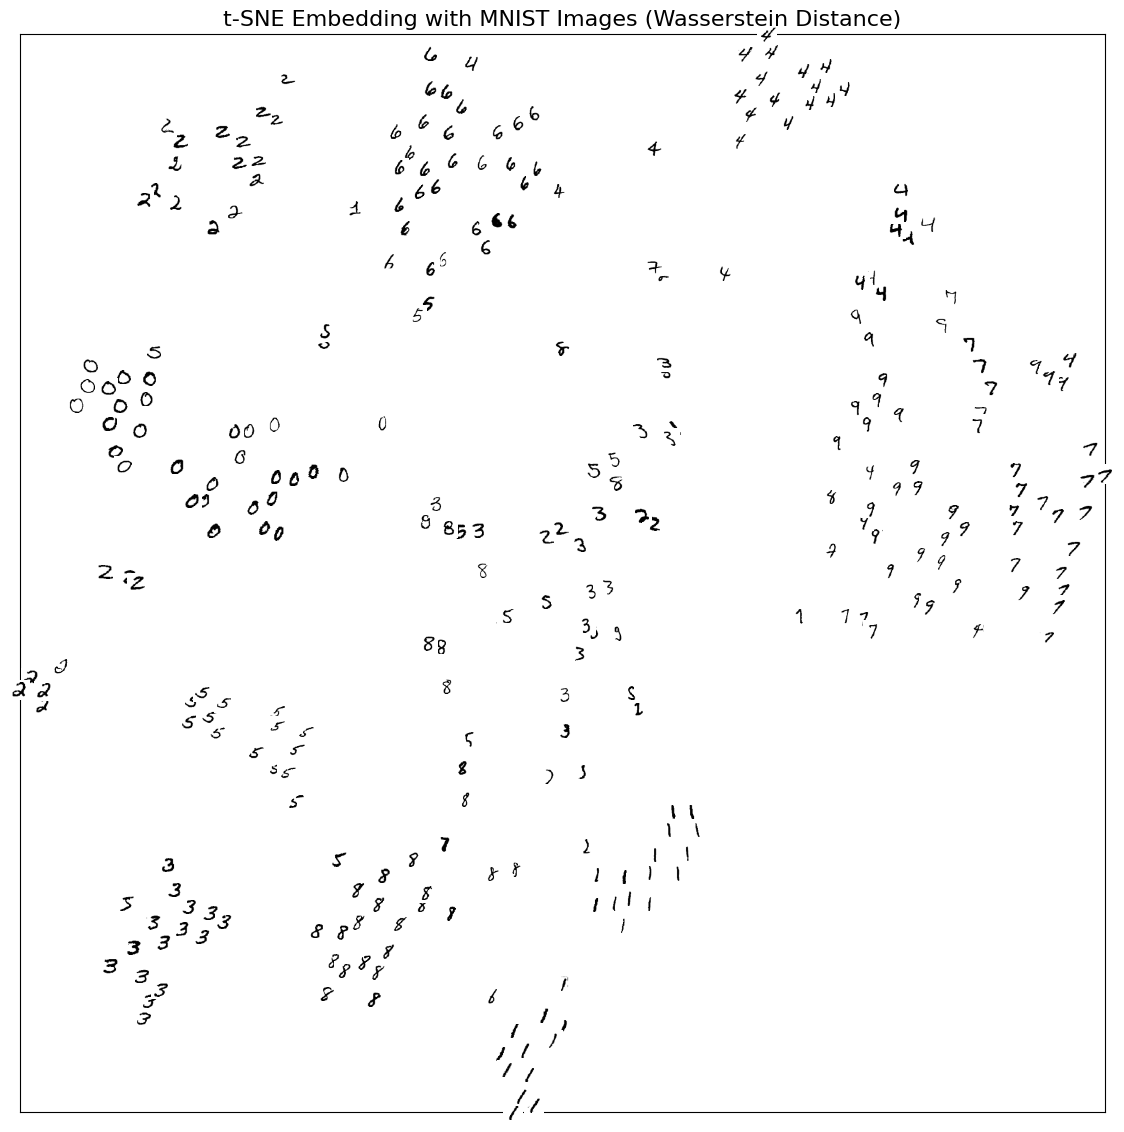

In [40]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# t-SNE Embedding with precomputed distance matrix
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42, perplexity=15)
embedding = tsne.fit_transform(D_ot)

# 1. Standard Visualization (Colored Markers)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=subset_labels, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, label='Digit Label')
plt.title("t-SNE Embedding using Wasserstein Distance (Colored Markers)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

# 2. Visualization with Images
def plot_embedding_images(X, images, title=None):
    # Normalize coordinates to [0, 1] for easier scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(14, 14))
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        # Reshape and normalize for display (0-1 range)
        img = images[i].reshape(28, 28)
        img = img / img.max() 
        
        # Create image box
        # zoom=0.5 controls the size of the images on the plot
        # cmap='gray_r' inverts the colors (black digit on white background)
        imagebox = OffsetImage(img, zoom=0.5, cmap='gray_r') 
        ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]), frameon=False, pad=0.0)
        ax.add_artist(ab)
    
    plt.xticks([]), plt.yticks([])
    if title:
        plt.title(title, fontsize=16)
    plt.show()

plot_embedding_images(embedding, subset_images, "t-SNE Embedding with MNIST Images (Wasserstein Distance)")